# SURE 2025 Speedy Simulations Kickoff
## Better Low Discrepancy Sequences

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

This notebook has been viewed (and perhaps modified) by
* Fred Hickernell
* Jimmy Nguyen
* Lijia Lin

## Preliminaries

### If you running this in Jupyter notebook and you have the environment set up, ignore the cell below
### If are running this notebook in on Google colab, replace False in the next cell by True

In [1]:
if False:  #Running on colab? # If you are running this on colab
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !sudo apt install cm-super
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2025

### Import needed packages

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
import timeit
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\kron}{\cp_{\textup{Kron}}}
\newcommand{\hK}{\widehat{K}}
\newcommand{\tb}{\widetilde{b}}
\newcommand{\hb}{\widehat{b}}
\newcommand{\MSD}{\textup{WSSD}}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Traditional grids

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly
$$
x_i = i/n, \qquad i = 0, \ldots, n-1.
$$
These are leaning towards the left, but one may add a shift to center them,
$$
x_i = (i+1/2)/n, \qquad i = 0, \ldots, n-1.
$$
Unfortunately, it is not easy to **extend** the sequence of points by increasing $n$.  One must in general throw out the old points.

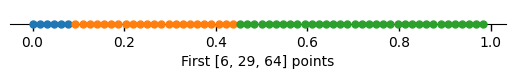

In [3]:
n_list = [6, 29, 64]  #the sample size used for these examples
xpts = np.linspace(0, 1-1./n_list[-1], n_list[-1]) #equally spaced points between 0 and 1
plt.style.use('default')
fig, ax = plt.subplots()
for ii,n in enumerate(n_list):
    n_start = 0 if ii == 0 else n_list[ii-1]
    ax.plot(xpts[n_start:n], np.zeros_like(xpts[n_start:n]), '.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
#ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
#ax.set_xlabel("$x_i$, ")
ax.set_xlabel(f"First {n_list} points")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.tick_params(axis='both', which='major', length=5, width=1)
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt,bbox_inches='tight')

### Grids in dimension $d > 1$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

The plots below show this effect.  Unfortunately, these grids are not 

In [4]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(0, 1.0-1/nper, nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

axis_pad = 0.05
def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = '', axis_pad = axis_pad, imgfrmt = 'pdf'):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0-axis_pad,1+axis_pad])
    ax.set_ylim([0-axis_pad,1+axis_pad])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


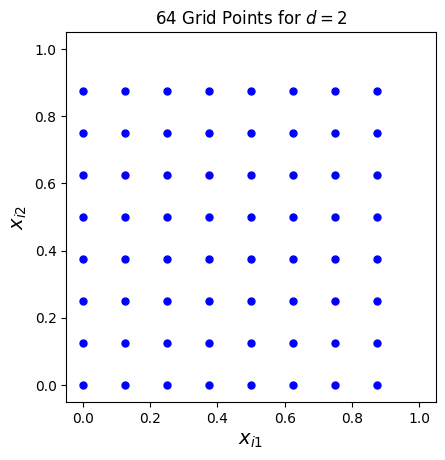

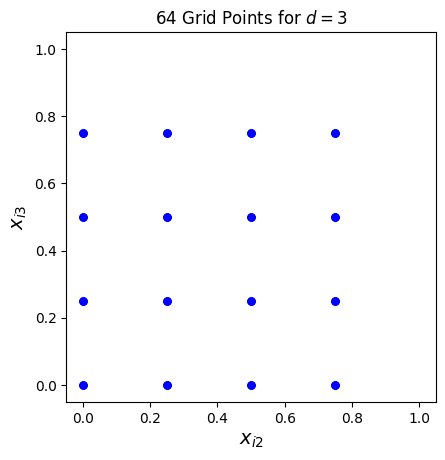

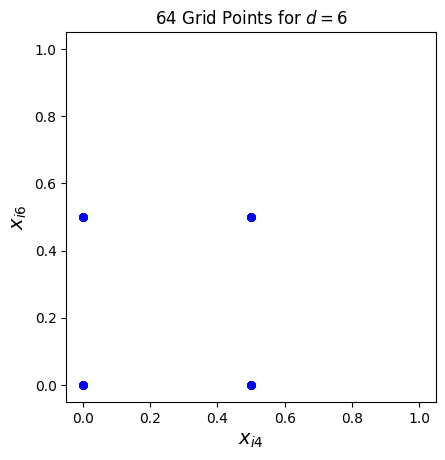

In [5]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

## Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

In [6]:
d = 6  #the dimension used for these examples
d_horiz = np.array([1])
d_vert = np.arange(2,5)
ms = 15

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

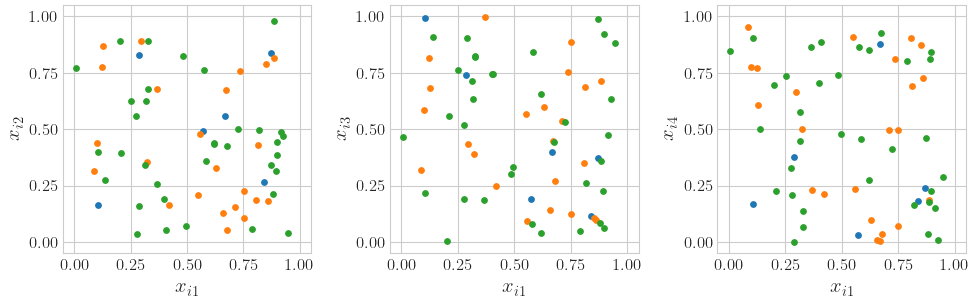

In [7]:
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n_list, d_horizontal = d_horiz, d_vertical = d_vert, figfac = 10, axis_pad = axis_pad, marker_size = ms, where_title = 0.55,fig_title = '')
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Low disrepancy sequences
There are several kinds of low discrepancy points, includng Sobol', lattice, Halton, and Kronecker.

### 1-dimensional low disrepancy sequences
We start with a one dimensional **extensible** sequence:
\begin{equation*}
\begin{aligned}
\textsf{van der Corput sequence} \quad & \phi_b((\cdots i_2 i_1 i_0)_b) = {}_b (0. i_0 i_1 i_2 \cdots) \\
\textsf{e.g. } & \phi_2(6) = \phi_2(110_2) = {}_2 0. 011 = 3/8
\end{aligned}
\end{equation*}
We and add a shift as well:
\begin{equation*}
x_i = \phi_b(i) + \Delta \bmod 1, \qquad i = 0, 1, 2, \ldots
\end{equation*}

Below we display one kind.

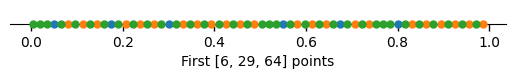

In [8]:
delta = 0.05  #the spacing between the points
xpts = np.mod(qp.DigitalNetB2(dimension=1,randomize=False).gen_samples(n_max=n_list[-1],warn=False) + delta,1) #generate a van de Corput sequence and add a shift
plt.style.use('default')
fig, ax = plt.subplots(1)
for ii,n in enumerate(n_list):
    n_start = 0 if ii == 0 else n_list[ii-1]
    ax.plot(xpts[n_start:n], np.zeros_like(xpts[n_start:n]), '.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_aspect(1)
ax.set_xlabel(f"First {n_list} points")
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.tick_params(axis='both', which='major', length=5, width=1)
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}VDCpts."+imgfrmt,format=imgfrmt,bbox_inches='tight')

### $d$-Dimensional integration lattices with a shift

\begin{equation*}
\boldsymbol{x}_i = \phi_b(i) \boldsymbol{h} + \boldsymbol{\Delta} \bmod \boldsymbol{1}, \qquad i = 0, 1, 2, \ldots
\end{equation*}


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

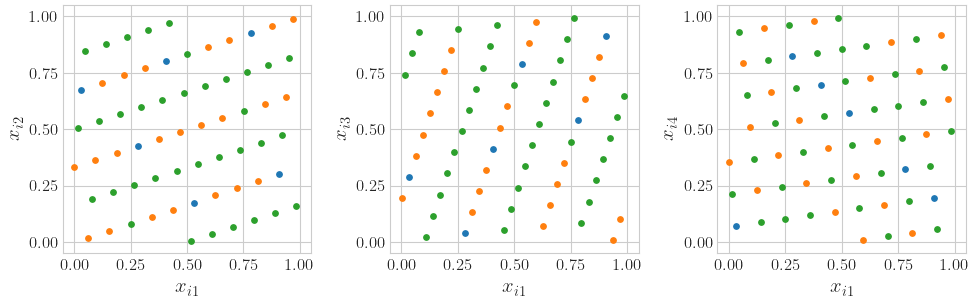

In [9]:
fig,ax = qp.plot_proj(qp.Lattice(d), n=n_list, d_horizontal = d_horiz, d_vertical = d_vert, figfac = 10, axis_pad = axis_pad, where_title = 0.55,marker_size=ms,fig_title = '')
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}lattice_pts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional Kronecker sequence with a shift

\begin{equation*}
\boldsymbol{x}_i = i \boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}, \qquad i = 0, 1, 2, \ldots
\end{equation*}

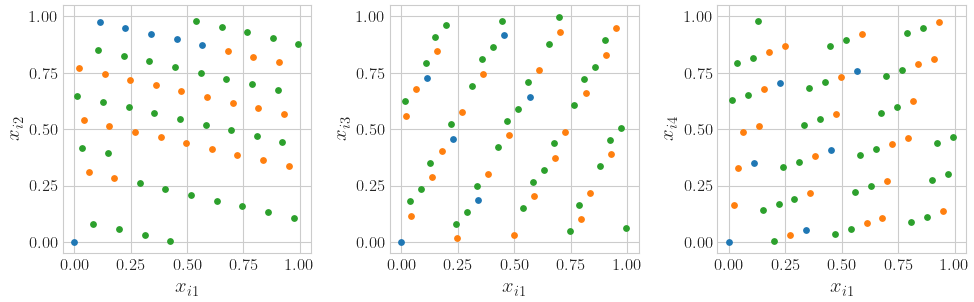

In [10]:
np.random.seed(47)
fig,ax = qp.plot_proj(qp.Kronecker(d,alpha = np.random.rand(d)), n=n_list, d_horizontal = d_horiz, d_vertical = d_vert, figfac = 10, axis_pad = axis_pad, where_title = 0.55,marker_size=ms,fig_title = '')
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}kronecker_pts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional Halton sequence

\begin{equation*}
\boldsymbol{x}_i = \bigl(\phi_{b_1}(i), \ldots, \phi_{b_d}(i) \bigr), \qquad i = 0, 1, 2, \ldots, \quad b_1 = 2, b_2 = 3, b_3 = 5, b_4 = 7, \ldots
\end{equation*}

/Users/jimmynguyen/QMCSoftware/qmcpy/discrete_distribution/halton.py:228


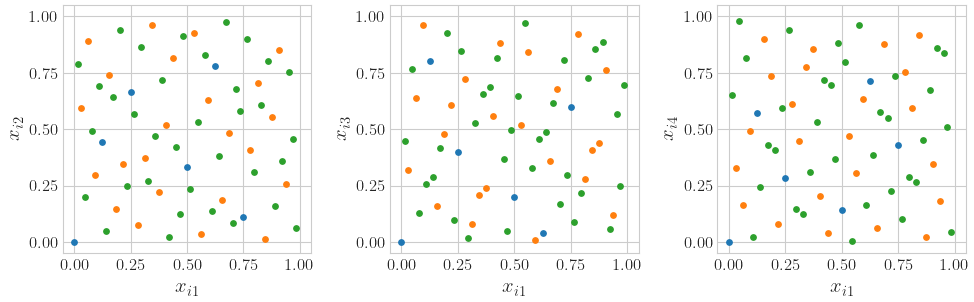

In [11]:
fig,ax = qp.plot_proj(qp.Halton(d, randomize = "FALSE"), n = n_list, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, axis_pad = axis_pad, marker_size=ms, where_title = 0.55, fig_title = "")
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}haltonpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### $d$-Dimensional Sobol' sequence

Scramble the digits of the $b=2$ van der Corput sequence for each coordinate

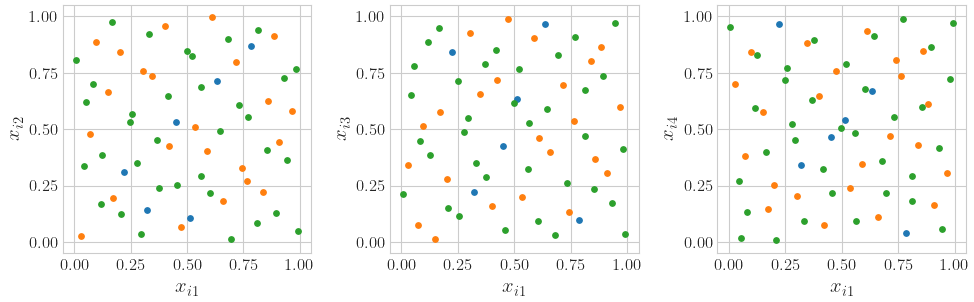

In [12]:
fig,ax = qp.plot_proj(qp.Sobol(d), n = n_list, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, axis_pad = axis_pad, marker_size = ms, where_title = 0.55, fig_title = "")
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Research Questions
<ul style="font-size:20px;">
<li>How well do Kronecker and lattice perform for non-preferred sample sizes?</li>
<li>How do we find a good generator $\boldsymbol{\alpha}$ for Kronecker?</li>
<li>Is there some generalization of Kronecker and lattice sequences that includes both?</li>
</ul>

## Kernel based discrepancies and random shifts leading to periodic kernels

One definition of discrepancy starts with a symmetric, positive definite kernel, $K:[0,1]^d\times [0,1]^d \to \mathbb{R}$, i.e.,
\begin{gather*}
K(\boldsymbol{t},\boldsymbol{x}) = K(\boldsymbol{x},\boldsymbol{t}) \qquad \forall \boldsymbol{t}, \boldsymbol{x} \in [0,1]^d \\
\sum_{i,j = 1}^{n} c_i K(\boldsymbol{x}_i,\boldsymbol{x}_j ) \boldsymbol{c}_j > 0 \qquad \forall \boldsymbol{c} \ne \boldsymbol{0}, \ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \text{ distinct and } \in [0,1]^d
\end{gather*}
The discrepancy, $D(\{\boldsymbol{x}\}_{i=1}^n)$ is defined in terms of the kernel as
$$
[D(\{\boldsymbol{x}_i\}_{i=1}^n,K)]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}
- \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i) \, \mathrm{d}\boldsymbol{t}
+ \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
The discrepancy requires $\mathcal{O}(dn^2)$ operations to compute, assuming one evaluation of the kernel requires $d$ operations to compute.

Now suppose that we take a set of nodes, $\{\boldsymbol{x}\}_{i=1}^n$, and we add the same random shift, $\boldsymbol{\Delta}$, modulo $\boldsymbol{1}$ to each node.  The root mean squared discrepancy is
$$
\begin{aligned}
\mathbb{E}\{[D(\{\boldsymbol{x}_i + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}  - \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i + \boldsymbol{z} \bmod \boldsymbol{1}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{z} \\
& \qquad + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} K(\boldsymbol{x}_i + \boldsymbol{z} \bmod \boldsymbol{1}, \boldsymbol{x}_j + \boldsymbol{z} \bmod \boldsymbol{1}) \, \mathrm{d}\boldsymbol{z} \\
& = - \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} K(\boldsymbol{x}_i - \boldsymbol{x}_j + \boldsymbol{z} \bmod \boldsymbol{1},\boldsymbol{z} ) \, \mathrm{d}\boldsymbol{z} \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n  \widetilde{K}(\boldsymbol{x}_i - \boldsymbol{x}_j \bmod \boldsymbol{1}), \qquad \text{where }  \, \widetilde{K}(\boldsymbol{t}) : = \int_{[0,1]^d} K(\boldsymbol{t} + \boldsymbol{x} \bmod \boldsymbol{1},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{x} \\
&= [D(\{\boldsymbol{x}_i\}_{i=1}^n,\widehat{K})]^2 \qquad \text{for } \widehat{K}(\boldsymbol{t},\boldsymbol{x}) : = \int_{[0,1]^d} K(\boldsymbol{t} + \boldsymbol{z} \bmod \boldsymbol{1}, \boldsymbol{x} + \boldsymbol{z} \bmod \boldsymbol{1}) \, \mathrm{d} \boldsymbol{z}
\end{aligned}
$$
This has the same cost to compute but a somewhat simpler form.


### Periodic kernels for Kronecker and lattice sequences

Now, let's evaluate the formula for the discrepancy for a randomly shifted Kronecker and lattice sequence:
$$
\begin{aligned}
\text{Kronecker: } \mathbb{E}\{[D(\{i\boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} \widetilde{K}((i - j)\boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& =  - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} 
+ \frac 1{n^2} \sum_{k=1-n}^{n-1}  (n -  \lvert k \rvert)\widetilde{K}(k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t}
+ \frac 1{n^2} \biggl[n \widetilde{K}(\boldsymbol{0}) +  2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \biggr] \\
\text{lattice: } \mathbb{E}\{[D(\{\phi_b(i)\boldsymbol{h} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = ??
\end{aligned}
$$

In [53]:
'''
Gives the discrepancy for a Kronecker sequence using the equation above.
Takes in a number of sample points n, a Kronecker object, and information about K_tilde.
Outputs the discrepancy values for n = 1,2,...,N
'''

# suppose K_tilde is a function with cost O(d) and int_k_tilde is a constant.
def kronecker_discrepancy(n, kronecker, k_tilde, int_k_tilde):
    k_tilde_zero = k_tilde(np.zeros(kronecker.dimension))
    k_tilde_zero_terms = np.full(n, k_tilde_zero) * (np.arange(n) + 1)
    
    return np.sqrt(((k_tilde_zero_terms + calculate_sum(n, kronecker, k_tilde))) / ((np.arange(n)+1) ** 2) - int_k_tilde)

'''
Takes in a number of sample points n>2, a Kronecker object, and a function K_tilde.
Outputs a 1xN array of terms corresponding to the summation term in the discrepancy formula.
'''
def calculate_sum(n, kronecker, k_tilde):
    points = qp.Kronecker(dimension=kronecker.dimension, alpha=kronecker.alpha).gen_samples(n) # array of k * alpha mod 1 terms
    k_tilde_terms = np.array([k_tilde(x) for x in points]) # evaluates k_tilde for every sample point
    cumsum_k_tilde = np.cumsum(k_tilde_terms) # cumsum of k_tilde points (same as left sum but offset)
    cumsum_weighted = np.cumsum((np.arange(n)+1) * k_tilde_terms) # same as right sum
    
    left_sum = np.roll(cumsum_k_tilde, 1) # sums to n-1
    left_sum[0] = 0 # first term is 0
    right_sum = np.roll(cumsum_weighted, 1)
    right_sum[0] = 0

    left_sum *= np.arange(n) + 1 # to get the "n times" component for each n = 1,2,...,N
    return 2 * (left_sum - right_sum)

$$
2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
= 2\left(n\sum_{k=1}^{n-1} \widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) - \sum_{k=1}^{n-1} k\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1})\right)
$$
The function calculate_sum() works by creating a 2xn array of values. The first row correpsonds to the first sum and the second row corresponds to the second sum.
The first row is initially calculated without multiplying by n = 1,2,...,N. We delay that multiplication to `sums[0] *= np.arange(n) + 1` at the end of the loop where `np.arange(n) + 1` is [1,2,...,N].

Since each n only adds one term to the previous sum, we can use a dynamic programming approach to find $2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1})$ for all n = 1,2,...,N in O(dN) time. We fill in 2N cells with each cell taking O(d) time to fill in. The for loop takes O(N) iterations and $\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1})$ takes O(d) to compute.

# Example with a Specified $\widetilde{K}$

Take $\widetilde{K}(x) = \prod_{\ell = 1}^d \left [1 + \gamma_\ell B_2(x_\ell) \right] = \prod_{\ell = 1}^d \left [1 + \gamma_\ell \left \{x_\ell(x_\ell - 1) + \frac 16 \right\}\right] $ with $d=2$ and $\gamma_\ell = 1$.

In [54]:
# Bernoulli polynomial kernel as written might be incorrect. There might be a 0.5 term somewhere.
def k_tilde(x):
    return (1 + x[0] * (x[0] - 1) + 1/6) * (1 + x[1] * (x[1] - 1) + 1/6)

In [55]:
# Compare to the easy O(dN^2) solution for correctness

def discrepancy(n, d, no_delta, k_tilde, int_k_tilde):
    total = 0
    for k in range(1,n):
        total += (n-k) * k_tilde(no_delta[k-1])
    return np.sqrt(((n*k_tilde(np.zeros(2)) + 2 * total) / (n**2)) - int_k_tilde)

def all_discrepancy(n, kronecker, k_tilde, int_k_tilde):
    array = np.zeros(n)
    no_delta = qp.Kronecker(dimension = kronecker.dimension, alpha = kronecker.alpha).gen_samples(n)
    for i in range(n):
        array[i] = discrepancy(i+1, 2, no_delta[:n], k_tilde, 1)

    return array

In [56]:
np.random.seed(0)
alpha = np.random.rand(2)
kronecker = qp.Kronecker(2, alpha)

In [57]:
all_discrepancy(100, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1)

array([0.60092521, 0.60092521, 0.50528513, 0.44293243, 0.39677706,
       0.36690019, 0.33677826, 0.30902761, 0.29532402, 0.27947864,
       0.26660446, 0.25403736, 0.24764123, 0.23842339, 0.23027449,
       0.22459787, 0.21860802, 0.2118437 , 0.20535894, 0.20091675,
       0.1950319 , 0.19061921, 0.18703049, 0.18426214, 0.18031806,
       0.17707163, 0.17418198, 0.17066413, 0.16713243, 0.16425915,
       0.16192544, 0.15872437, 0.15676884, 0.15477264, 0.15279515,
       0.1503542 , 0.14870343, 0.14691751, 0.14463156, 0.14272749,
       0.14085994, 0.13923043, 0.13714076, 0.13614461, 0.13482666,
       0.1333859 , 0.13189219, 0.13063267, 0.1291912 , 0.12745248,
       0.1263964 , 0.12508574, 0.12398906, 0.12272488, 0.12197316,
       0.12089037, 0.11973032, 0.11881916, 0.11781052, 0.11668722,
       0.11545393, 0.11469979, 0.11363907, 0.11276777, 0.11197229,
       0.11129263, 0.11035771, 0.10944416, 0.10870735, 0.10777127,
       0.10683729, 0.10596757, 0.1053447 , 0.10445382, 0.10377

In [58]:
kronecker_discrepancy(100, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1)

array([0.60092521, 0.60092521, 0.50528513, 0.44293243, 0.39677706,
       0.36690019, 0.33677826, 0.30902761, 0.29532402, 0.27947864,
       0.26660446, 0.25403736, 0.24764123, 0.23842339, 0.23027449,
       0.22459787, 0.21860802, 0.2118437 , 0.20535894, 0.20091675,
       0.1950319 , 0.19061921, 0.18703049, 0.18426214, 0.18031806,
       0.17707163, 0.17418198, 0.17066413, 0.16713243, 0.16425915,
       0.16192544, 0.15872437, 0.15676884, 0.15477264, 0.15279515,
       0.1503542 , 0.14870343, 0.14691751, 0.14463156, 0.14272749,
       0.14085994, 0.13923043, 0.13714076, 0.13614461, 0.13482666,
       0.1333859 , 0.13189219, 0.13063267, 0.1291912 , 0.12745248,
       0.1263964 , 0.12508574, 0.12398906, 0.12272488, 0.12197316,
       0.12089037, 0.11973032, 0.11881916, 0.11781052, 0.11668722,
       0.11545393, 0.11469979, 0.11363907, 0.11276777, 0.11197229,
       0.11129263, 0.11035771, 0.10944416, 0.10870735, 0.10777127,
       0.10683729, 0.10596757, 0.1053447 , 0.10445382, 0.10377

In [59]:
print((all_discrepancy(1000, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1) - kronecker_discrepancy(1000, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1)))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.77555756e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.33066907e-16
  7.21644966e-16  3.88578059e-16  3.88578059e-16 -4.44089210e-16
  4.44089210e-16  4.71844785e-16  4.99600361e-16  4.99600361e-16
  5.27355937e-16  1.05471187e-15  0.00000000e+00  1.11022302e-15
  1.13797860e-15  5.82867088e-16  1.19348975e-15  6.10622664e-16
  0.00000000e+00  1.24900090e-15  6.38378239e-16  6.66133815e-16
  6.66133815e-16 -6.66133815e-16  1.36002321e-15  0.00000000e+00
  1.41553436e-15  1.44328993e-15  0.00000000e+00  7.21644966e-16
 -7.49400542e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.60982339e-15  0.00000000e+00  8.04911693e-16
  0.00000000e+00  0.00000000e+00  8.60422844e-16  8.60422844e-16
  2.58126853e-15  1.74860126e-15 -8.88178420e-16  1.77635684e-15
  1.79023463e-15  1.80411242e-15  3.63598041e-15  3.67761377e-15
  0.00000000e+00  9.29811783e-16  0.00000000e+00  9.43689571e-16
  1.92901251e-15  0.00000

In [38]:
n_squared = all_discrepancy(50000, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1)

In [40]:
n = kronecker_discrepancy(50000, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1)

In [43]:
for i in range(50000):
    print(n_squared[i] - n[i])


# difference seems to be about 0? for each term, the first 14-16 digits match so it might be a precision problem instead of a math one

0.0
0.0
0.0
-2.7755575615628914e-16
0.0
0.0
0.0
3.3306690738754696e-16
7.216449660063518e-16
3.885780586188048e-16
3.885780586188048e-16
-4.440892098500626e-16
4.440892098500626e-16
4.718447854656915e-16
4.996003610813204e-16
4.996003610813204e-16
5.273559366969494e-16
1.0547118733938987e-15
0.0
1.1102230246251565e-15
1.1379786002407855e-15
5.828670879282072e-16
1.1934897514720433e-15
6.106226635438361e-16
0.0
1.2490009027033011e-15
6.38378239159465e-16
6.661338147750939e-16
6.661338147750939e-16
-6.661338147750939e-16
1.3600232051658168e-15
0.0
1.4155343563970746e-15
1.4432899320127035e-15
0.0
7.216449660063518e-16
-7.494005416219807e-16
0.0
0.0
0.0
0.0
1.609823385706477e-15
0.0
8.049116928532385e-16
0.0
0.0
8.604228440844963e-16
8.604228440844963e-16
2.581268532253489e-15
1.7486012637846216e-15
-8.881784197001252e-16
1.7763568394002505e-15
1.790234627208065e-15
1.8041124150158794e-15
3.635980405647388e-15
3.677613769070831e-15
0.0
9.298117831235686e-16
0.0
9.43689570931383e-16
1.9290

In [20]:
print(np.allclose(all_discrepancy(100, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1),kronecker_discrepancy(100, qp.Kronecker(dimension=2,alpha=alpha), k_tilde, 1)))

True


In [60]:
np.random.seed(42)
alpha = np.random.rand(2)
kronecker = qp.Kronecker(2, alpha)

for i in [10,100,1000,10000]:
    print(f'Time for brute force, n = {i}: {timeit.timeit(lambda: all_discrepancy(i, kronecker, k_tilde, 1), number=3) / 3}') # takes the average over 3 tries
    print(f'Time for new solution, n = {i}: {timeit.timeit(lambda: kronecker_discrepancy(i, kronecker, k_tilde, 1), number=3) / 3}')
    print()

Time for brute force, n = 10: 7.315266702789813e-05
Time for new solution, n = 10: 0.0002518056668729211

Time for brute force, n = 100: 0.003505944667267613
Time for new solution, n = 100: 0.0001519860015832819

Time for brute force, n = 1000: 0.3256204723317448
Time for new solution, n = 1000: 0.0008024583342679156

Time for brute force, n = 10000: 31.46866581933379
Time for new solution, n = 10000: 0.00626245833215459



In [64]:
print(f'Time for new solution, n = {100000000}: {timeit.timeit(lambda: kronecker_discrepancy(100000000, kronecker, k_tilde, 1), number=5) / 5}')

Time for new solution, n = 100000000: 66.72349988339992


### Weighted Sum of Squares of Discrepancy

In [ ]:
# weights are real valued
def calculate_beta(weights):
    return np.cumsum(weights)

In [ ]:
def kron_wssd(n, kronecker, weights, k_tilde, int_k_tilde):
    k_tilde_zero = k_tilde(np.zeros(kronecker.dimension))
    k_tilde_zero_terms = np.full(n, k_tilde_zero) * (np.arange(n) + 1)

    return k_tilde_zero_terms * np.cumsum(weights)


# # suppose K_tilde is a function with cost O(d) and int_k_tilde is a constant.
# def kronecker_discrepancy(n, kronecker, k_tilde, int_k_tilde):
#     k_tilde_zero = k_tilde(np.zeros(kronecker.dimension))
#     k_tilde_zero_terms = np.full(n, k_tilde_zero) * (np.arange(n) + 1)
    
#     return np.sqrt(((k_tilde_zero_terms + calculate_sum(n, kronecker, k_tilde))) / ((np.arange(n)+1) ** 2) - int_k_tilde)

# '''
# Takes in a number of sample points n>2, a Kronecker object, and a function K_tilde.
# Outputs a 1xN array of terms corresponding to the summation term in the discrepancy formula.
# '''
# def calculate_sum(n, kronecker, k_tilde):
#     points = qp.Kronecker(dimension=kronecker.dimension, alpha=kronecker.alpha).gen_samples(n) # array of k * alpha mod 1 terms
#     k_tilde_terms = np.array([k_tilde(x) for x in points]) # evaluates k_tilde for every sample point
#     cumsum_k_tilde = np.cumsum(k_tilde_terms) # cumsum of k_tilde points (same as left sum but offset)
#     cumsum_weighted = np.cumsum((np.arange(n)+1) * k_tilde_terms) # same as right sum
    
#     left_sum = np.roll(cumsum_k_tilde, 1) # sums to n-1
#     left_sum[0] = 0 # first term is 0
#     right_sum = np.roll(cumsum_weighted, 1)
#     right_sum[0] = 0

#     left_sum *= np.arange(n) + 1 # to get the "n times" component for each n = 1,2,...,N
#     return 2 * (left_sum - right_sum)

In [22]:
print("finished running notebook")

finished running notebook
